# 521153S, Deep Learning Final Project: Mini Image classification Competition with CNN

## Outline 
### In this assignment, you will learn:
* Combine all you learned from the previous assignments.
* Build your own CNN as you like with Pytorch, train and validate it on a given dataset.
* Test your CNN model on our server.

### Tasks (<span style="color:orange">40 points</span>)
We want to keep the task as clean and simple as possible. 
1. You would be given a dataset containing 45,000 grayscale 32x32 images. Also, we will set a private testing data and upload it to our server. You could only use the private testing data to test your model. Instructions about evaluating your model would be given along with the project in Moodle.
2. Before evaluating your model on the server, you have to train your model based on the given 45,000 images. Specifically, in these images, there are nine classes, and each class has 5000 images. The testing data on the server has 9000 images, and each class has 1000 images.
3. To get a good CNN model, basically, there are some rules for you to follow which would be considered when grading your report:
  * Make the best out of the given images. It means you have to split it into training and validation set, training your model on the training set and validating the trained model on the validation set. If the accuracy on the validation set is not good, then you have to adjust your CNN model structure or some adjustable parameters. For example, batch size, learning rate, momentum on SGD, lambda in weight decay, etc.  Then retrain your model until the accuracy on the validation set is good enough because the testing data would have similar accuracy with the validation set. 
  * It also means that you could do some augmentation on the training set. This includes randomly flipping, cropping a small window in a random location within the image(refer to assignment 4), adding some noise, resizing-and-cropping, etc. All these are to make the training process more tolerant. 
  * From the CNN structure perspective, you also need to design your CNN model by yourself. Well-known network architecture you can use includes [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/abs/1512.00567), [VGGNet](https://arxiv.org/abs/1409.1556), [DenseNet](https://arxiv.org/abs/1608.06993), [MobileNet](https://arxiv.org/abs/1801.04381), [ShuffleNet](https://arxiv.org/abs/1807.11164), [ResNeXt](https://arxiv.org/abs/1611.05431) etc. 
4. Similar to real-life applications, your model will be tested with unknown data. In this project,  after training and validating the model, you need to test it on our hold-on testing dataset. We will provide you with a submission server and a leaderboard. The instructions would be given alongside the project in Moodle. 
5. Please give a pdf report (also your source code, e.g., this Jupyter notebook file), documenting the whole model training process and also the evaluated accuracy on the server. Tensorboard visualization is also necessary for your report to visualize your network structure, accuracy, and losses, etc. as done in assignment 4.
6. You need to return the pdf report as well as your trained model (a checkpoint file) with your source code file to moodle. We will run your model on the server and compare the results with the one written in the reports. 

### Grading
You can get 40 points in total.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your model achieve more than 82.5% of the testing accuracy.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your report is clear and well-organized.
  
### Files you have to submit
please submit a .zip file containing:
1. a pdf report;
2. source code files (jupyter notebook or common python files);
3. a checkpoint file (which saves your trained model).

### Group members
Maximum 2 members. 


### Environment
Python 3, Numpy, matplotlib, torch, torchvision...

### Dataset
Please follow the code below to download the 45,000 images and corresponding labels. <br>
We have already split them into training and validation set; please refer to assignment 3 and 4 to create your DataLoader, with your data augmentation methods. Good luck. 

#### Download the given dataset

In [1]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torchvision.models.resnet import BasicBlock
from torch.utils.tensorboard import SummaryWriter

download_given_data('./')

print(torch.cuda.is_available())

Data was already downloaded and extracted!
True


In [2]:
#define a class to get data
class Data(Dataset):
    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
               'frog', 'horse', 'ship']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

In [3]:
#get training and validation data, they are predefined in the downloaded dataset
train_set = Data(csv_file='./given_data/train.csv', transform=None)
valid_set = Data(csv_file='./given_data/val.csv', transform=None)
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship']

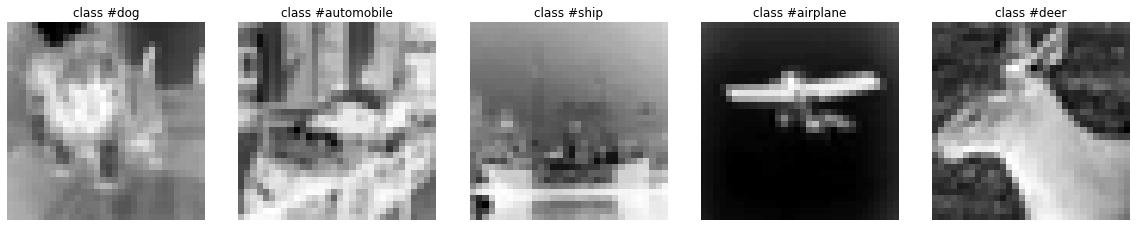

total number of training set: 36000
number of images for class airplane: 4000
number of images for class automobile: 4000
number of images for class bird: 4000
number of images for class cat: 4000
number of images for class deer: 4000
number of images for class dog: 4000
number of images for class frog: 4000
number of images for class horse: 4000
number of images for class ship: 4000


In [4]:
#check training set
num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    image_ = np.squeeze(image) #used to be able to display tensor images
    plt.imshow(np.asarray(image_), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(9, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(9):
    print('number of images for class {}: {}'.format(label_names[i], class_num_train[i]))

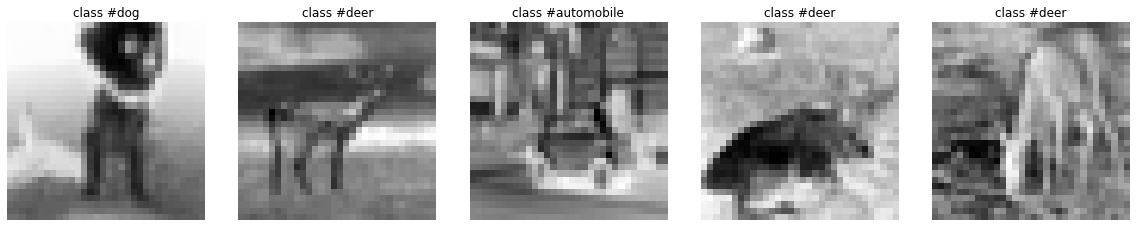

total number of validation set: 9000
number of images for class airplane: 1000
number of images for class automobile: 1000
number of images for class bird: 1000
number of images for class cat: 1000
number of images for class deer: 1000
number of images for class dog: 1000
number of images for class frog: 1000
number of images for class horse: 1000
number of images for class ship: 1000


In [5]:
#check validation set
num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    image_ = np.squeeze(image) #used to be able to display tensor images
    plt.imshow(np.asarray(image_), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the validation set
print('total number of validation set: {}'.format(len(valid_set)))

# Print the number of images per class in the training set
class_num_valid = np.zeros(9, dtype=np.int32)
for x in valid_set:
    class_num_valid[x['label']] += 1
for i in range(9):
    print('number of images for class {}: {}'.format(label_names[i], class_num_valid[i]))

In [6]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size

    def __call__(self, sample):
        image = sample

        # Perform RandomWindowDrop
        h, w = image.size
        imagePixels = image.load()
        top = np.random.randint(self.window_size[0], h - self.window_size[0])
        left = np.random.randint(self.window_size[1], w - self.window_size[1])
        for i in range(top, top+self.window_size[0], 1):
            for j in range(left, left+self.window_size[1], 1):   
                imagePixels[i, j] = 0

        return image

In [11]:
#augment training data - flipping, cropping a small window in a random location within the image (refer to assignment 4), adding some noise, resizing-and-cropping
__normalize_stats = {'mean': [0.0], 'std': [1.0]} #WIGGLE
data_transform_basic = transforms.Compose([transforms.Resize(224),transforms.ToTensor(), transforms.Normalize(__normalize_stats['mean'],__normalize_stats['std'])])
#WIGGLE
data_transform_full = transforms.Compose([transforms.Resize(224),transforms.RandomHorizontalFlip(p = 1.0), RandomWindowDrop(6), transforms.ToTensor(), transforms.Normalize(__normalize_stats['mean'],__normalize_stats['std'])]) #experiment here
train_set_ntr = Data(csv_file='./given_data/train.csv', transform = data_transform_basic)
train_set_tr = Data(csv_file='./given_data/train.csv', transform = data_transform_full)
train_set = np.concatenate((train_set_ntr, train_set_tr))
print('Length of our augmented training dataset is', len(train_set))
valid_set = Data(csv_file='./given_data/val.csv', transform = data_transform_basic)
#valid_set_tr = Data(csv_file='./given_data/val.csv', transform = data_transform_full)
#valid_set = concatenate(valid_set_ntr, valid_set_tr)

Length of our augmented training dataset is 72000


In [12]:
#prepare training and validation dataset loaders using DataLoader
no_workers = 0 #more than 0 causes some problems on Windows 7, Python 3.6.8
btch_size = 64 #WIGGLE
train_loader = DataLoader(train_set, batch_size=btch_size, shuffle=True, num_workers=no_workers)
valid_loader = DataLoader(valid_set, batch_size=btch_size, shuffle=False, num_workers=no_workers)

In [ ]:
#define our network, inputs are grayscale 32x32 images
#from assignment 4
#with batch size 32, 5 epoches, 0 weight decay, 64,7% val_acc
#with batch size 8, 10 epoches, 0.0005 weight decay, 64% val_acc
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = self.relu1
        self.max_pool2 = self.max_pool1
        self.fc3 = nn.Linear(12*8*8, 128)
        self.relu3 = self.relu1
        self.fc4 = nn.Linear(128,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)     
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)     
        x = self.max_pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        
        return x

In [ ]:
#define our network, inputs are grayscale 32x32 images, WIGGLE
#modified (less deep, smaller input images) VGG16 - does not work YET
class Network(nn.Module):
    def __init__(self, num_classes):
        """
        Constructor
        """
        super().__init__()
#         self.block_size = [2, 2, 3, 3]

        ## Define Block of VGG16
        
        # Block 1
        self.conv_1_1 = nn.Conv2d(1, 4, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(4, 4, 3, stride=1, padding=1)
        
        # Block 2
        self.conv_2_1 = nn.Conv2d(4, 8, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(8, 8, 3, stride=1, padding=1)
        
        # Block 3
        self.conv_3_1 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        
        # Block 4
        self.conv_4_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        
        # Block 5
#         self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
#         self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
#         self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        
        self.fc6 = nn.Linear(16 * 4 * 4, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc8 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
                    
    # Forward step 
    def forward(self, x):
        """ Pytorch forward

        Args:
            x: input image (32x32, originally in VGG16 224x224)

        Returns: class logits

        """
        x = self.relu(self.conv_1_1(x))
        x = self.relu(self.conv_1_2(x))
        x1 = self.max_pool(x)
        
        x2 = self.relu(self.conv_2_1(x1))
        x2 = self.relu(self.conv_2_2(x2))
        x2 = self.max_pool(x2) #started to improve after about 8000 samples with lr 0.01, batch size 8
        
        x3 = self.relu(self.conv_3_1(x2))
        x3 = self.relu(self.conv_3_2(x3))
        x3 = self.relu(self.conv_3_3(x3))
        x5 = self.max_pool(x3)
        
#         x4 = self.relu(self.conv_4_1(x3))
#         x4 = self.relu(self.conv_4_2(x4))
#         x5 = self.relu(self.conv_4_3(x4))
#         x5 = F.max_pool2d(x4, 2, 2)
        
#         x5 = F.relu(self.conv_5_1(x4))
#         x5 = F.relu(self.conv_5_2(x5))
#         x5 = F.relu(self.conv_5_3(x5))
#         x5 = F.max_pool2d(x5, 2, 2)
        
        x6 = x5.view(x5.size(0), -1)
        x7 = self.relu(self.fc6(x6))
#         x6 = F.dropout(x6, 0.5, self.training)
#         x7 = self.relu(self.fc7(x6))
#         x7 = F.dropout(x7, 0.5, self.training)
        return self.fc8(x7)

In [15]:
class VGG_16(nn.Module):

    def __init__(self, num_classes):
        """
        Constructor
        """
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]

        ## Define Block of VGG16
        
        # Block 1
        self.conv_1_1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        
        # Block 2
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        
        
        # Block 3
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        
        
        # Block 4
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        
        
        # Block 5
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

        
        
    
    # Load pretrained weight from .t7 file, which is not frequently used nowadays. 
    def load_weights(self, path="VGG_FACE.t7"):
        """ Function to load luatorch pretrained

        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path, force_8bytes_long=True)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                elif block < 8:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

                    
    # Forward step 
    def forward(self, x):
        """ Pytorch forward

        Args:
            x: input image (224x224)

        Returns: class logits

        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x1 = F.max_pool2d(x, 2, 2)
        
        
        
        x2 = F.relu(self.conv_2_1(x1))
        x2 = F.relu(self.conv_2_2(x2))
        x2 = F.max_pool2d(x2, 2, 2)
        
        x3 = F.relu(self.conv_3_1(x2))
        x3 = F.relu(self.conv_3_2(x3))
        x3 = F.relu(self.conv_3_3(x3))
        x3 = F.max_pool2d(x3, 2, 2)
        
        
        x4 = F.relu(self.conv_4_1(x3))
        x4 = F.relu(self.conv_4_2(x4))
        x4 = F.relu(self.conv_4_3(x4))
        x4 = F.max_pool2d(x4, 2, 2)
        
        
        x5 = F.relu(self.conv_5_1(x4))
        x5 = F.relu(self.conv_5_2(x5))
        x5 = F.relu(self.conv_5_3(x5))
        x5 = F.max_pool2d(x5, 2, 2)
        
        x6 = x5.view(x5.size(0), -1)
        x6 = F.relu(self.fc6(x6))
        x6 = F.dropout(x6, 0.5, self.training)
        
        x7 = F.relu(self.fc7(x6))
        x7 = F.dropout(x7, 0.5, self.training)
        
        return self.fc8(x7)

In [10]:
#Create a train writer and a validation writer
#After training, to open tensorboard run
#cd Skola/Erasmus/SUBJECTS/Deep Learning/Final_project
#tensorboard --logdir tb_graphs/ --port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

VGG_16(
  (conv_1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_3): 

RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 2.32 GiB already allocated; 716.26 MiB free; 14.22 MiB cached)

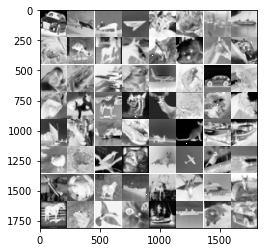

In [17]:
# instantiate a network
net = VGG_16(num_classes=9)

net = net.cuda()
    
# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image'].cuda()

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(net, images)

In [ ]:
# evaluation function
def eval(net, loss_function, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    for i, sample in enumerate(data_loader):
        images, labels = sample['image'], sample['label']
        outs = net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs, labels).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# training function
def train(net, train_loader, valid_loader, writer, val_writer, loss_function):
    optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0) #WIGGLE

    # Log training process to tensorboard every 100 iterations
    log_every = 100
    # For how many epoches will we train
    epoches = 5 #WIGGLE
    for epoch in range(epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):
            images, labels = sample['image'], sample['label']
            outs = net(images)
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            
            # clear gradients, back-propagation, backward propogation, update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                        
            running_loss += loss.item()
            
            
            if i % log_every == 99: 
                
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch+1, i+1, 
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                writer.add_scalar('Loss', running_loss / log_every, log_index)
                writer.add_scalar('Accuracy', running_acc / log_every, log_index)
                

                # Log predictions
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0

        
        # Running the validation
        acc_eval, loss_eval = eval(net, loss_function, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch+1, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        # Log the validation loss and accuracy
        val_writer.add_scalar('Loss', loss_eval, log_index)
        val_writer.add_scalar('Accuracy', acc_eval, log_index)
        

    return net

In [ ]:
print('Please wait patiently, it may take some time...')
loss_function = torch.nn.CrossEntropyLoss()
train(net, train_loader, valid_loader, writer, val_writer, loss_function)

# Save the weight of current model to disk
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

# Load the model weights from './net.pth'
net.load_state_dict(torch.load('./net.pth'))

# Close the training and validation writer
writer.close()
val_writer.close()